# Extracting Features from Text Variables

## Định nghĩa
Dữ liệu văn bản (text) là một dạng dữ liệu phổ biến, các biến dữ liệu văn bản cũng là một phần quan trọng chứa thông tin trong một tập dữ liệu. Dạng dữ liệu này có thể thấy ở nhiều dạng khác nhau từ bảng biểu, tài liệu, báo cáo...<br>
Dữ liệu văn bản là dữ liệu phi cấu trúc, nói cách khác dữ liệu này sẽ không tuân theo một mẫu nhất định như dạng bản biểu thường thấy trong các tập dữ liệu. Bên cạnh đó, dữ liệu dạng văn bản sẽ có độ dài đa dạng cũng như nhiều phong cách viết ứng với nội dung và hình thức mà văn bản đó muốn thể hiện.<br>
Xử lý ngôn ngữ tự nhiên (Natural Language Processing - NLP) là một mảng trong lĩnh vực ngôn ngữ học và khoa học máy tính, là giao thoa giữa máy tính và ngôn ngữ con người, giúp cho máy tính có thể hiểu được ngôn ngữ của con người. Kỹ thuật này bao gồm tìm hiểu về ngữ nghĩa, cú pháp, và diễn giải văn bản.




## Thư viện cần thiết

*   Pandas
*   scikit-learn
*   [NLTK](https://pypi.org/project/nltk/) (Sử dụng phân tích ngôn ngữ Anh)
*   [Pyvi](https://pypi.org/project/pyvi/) (Sử dụng phân tích ngôn ngữ Việt)

Ngoài ra một số thư viện khác có thể áp dụng với tiếng Việt bao gồm [Underthesea](https://github.com/undertheseanlp/underthesea) và [VnCoreNLP](https://github.com/vncorenlp/VnCoreNLP)

In [ ]:
!pip install -q nltk pyvi underthesea scikit-learn datasets seaborn==0.12.2 spacy==3.5.3 wordcloud yellowbrick Pillow
!pip install --upgrade scikit-learn Pillow
!wget https://huggingface.co/tpha4308/keyword-extraction-viet/resolve/main/vietnamese-stopwords-dash.txt?download=true -O vietnamese-stopwords-dash.txt

--2024-12-26 07:43:37--  https://huggingface.co/tpha4308/keyword-extraction-viet/resolve/main/vietnamese-stopwords-dash.txt?download=true
Resolving huggingface.co (huggingface.co)... 18.238.176.8, 18.238.176.118, 18.238.176.103, ...
Connecting to huggingface.co (huggingface.co)|18.238.176.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20830 (20K) [text/plain]
Saving to: ‘vietnamese-stopwords-dash.txt’

vietnamese-stopword 100%[===================>]  20.34K  --.-KB/s    in 0s      

2024-12-26 07:43:37 (45.5 MB/s) - ‘vietnamese-stopwords-dash.txt’ saved [20830/20830]



In [ ]:
import pandas as pd
from datasets import load_dataset
# Tải dữ liệu từ 20 Newsgroup
from sklearn.datasets import fetch_20newsgroups


data = fetch_20newsgroups(subset='train')
df = pd.DataFrame(data.data, columns=['text'])

## Các kỹ thuật triển khai
Một số kỹ thuật sử dụng nhằm trích xuất thông tin từ biến văn bản:


1.   Đếm ký tự, chữ, và tự điển
2.   Đánh giá độ phức tạp của văn bản thông qua đếm câu
3.   Tạo thuộc tính thông qua kỹ thuật bag-of-words, n-grams, TF-IDF
4.   Làm sạch và chuẩn hóa dữ liệu với stemming và lemmatization



### 1. Đếm ký tự, chữ và tự điển
Một trong những đặc điểm của dữ liệu văn bản là tính phức tạp. Văn bản càng dài càng chứa nhiều thông tin. Hơn thế nữa, văn bản sử dụng đa dạng các từ vựng sẽ chứa thông tin đa dạng và chi tiết hơn văn bản chỉ lặp từ nhiều lần. Bên cạnh đó, những loại từ như mạo từ, giới từ, trạng từ,... dùng để xây dựng câu, song nội dung chính sẽ tập trung vào danh từ, tính từ. Vì vậy, đôi khi không cần đọc hết văn bản, thông tin vẫn có thể được trích xuất sơ bộ thông qua xác định số từ, đa dạng từ vựng, và độ dài của mỗi từ (từ ghép)<br>

#### Xác định số lượng ký tự
Ký tự hay chữ cái là đơn vị nhỏ nhất cấu thành nên từ và văn bản. Trong tiếng Anh sẽ là 26 chữ cái và tiếng Việt là 29 chữ cái. Trong xử lý dữ liệu văn bản, ký tự sẽ bao gồm cả khoảng trắng (whitespace), dấu câu (punctuations) hay các ký tự đặc biệt. Nhằm giảm thiểu ảnh hưởng trong quá trình trích xuất dữ liệu, nên loại bỏ các đối tượng này khi khảo sát. Việc này hỗ trợ chúng ta biết được độ dài văn bản theo đơn vị cơ bản nhất.

In [ ]:
# Xác định số lượng ký tự - number of characters in text
df['num_char'] = df['text'].str.strip().str.len()
df.head()

,text,num_char
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,716
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,857
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,1980
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,814
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,1117


#### Xác định số lượng từ
Từ được cấu thành từ chữ cái và là đơn vị xây dựng lên câu. Khi khảo sát độ dài câu theo mức độ ký tự, chúng ta chỉ biết thông tin là độ dài của văn bản, chưa thể hiện rõ sự đa dạng về từ sử dụng trong văn bản. Vì vậy cần khảo sát độ dài của văn bản theo mức độ từ

**Note** Khi chọn `split(" ")`, kí tự mặc định để phân chia sẽ là whitespace `\s` nên khi phân, tiến trình sẽ bỏ qua các ký tự space khác như `\n, \t, \r`. Điều này sẽ làm ảnh hưởng đến quá trình phân tích độ dài của văn bản, cần lưu ý khi sử dụng.

In [ ]:
df['num_words'] = df['text'].str.split().str.len()
df.head()

,text,num_char,num_words,num_vocab,lexical_div,ave_word_length
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,716,123,93,1.225806,6.280702
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,857,123,99,1.080808,8.009346
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,1980,339,219,1.461187,6.187500
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,814,113,96,0.989583,8.568421
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,1117,171,139,1.143885,7.025157


In [ ]:
test_text = df["text"].iloc[3]
print(repr(test_text.strip()))
print(test_text.strip().split(" ")) # Phân tách chuỗi với chỉ kí tự khoảng trắng
print(test_text.strip().split()) # Phân tách chuỗi với toàn bộ kí tự khoảng trắng, xuống dòng,...
print(len(test_text.strip().split(" ")))
print(len(test_text.strip().split()))

'From: jgreen@amber (Joe Green)\nSubject: Re: Weitek P9000 ?\nOrganization: Harris Computer Systems Division\nLines: 14\nDistribution: world\nNNTP-Posting-Host: amber.ssd.csd.harris.com\nX-Newsreader: TIN [version 1.1 PL9]\n\nRobert J.C. Kyanko (rob@rjck.UUCP) wrote:\n> abraxis@iastate.edu writes in article <abraxis.734340159@class1.iastate.edu>:\n> > Anyone know about the Weitek P9000 graphics chip?\n> As far as the low-level stuff goes, it looks pretty nice.  It\'s got this\n> quadrilateral fill command that requires just the four points.\n\nDo you have Weitek\'s address/phone number?  I\'d like to get some information\nabout this chip.\n\n--\nJoe Green\t\t\t\tHarris Corporation\njgreen@csd.harris.com\t\t\tComputer Systems Division\n"The only thing that really scares me is a person with no sense of humor."\n\t\t\t\t\t\t-- Jonathan Winters'
['From:', 'jgreen@amber', '(Joe', 'Green)\nSubject:', 'Re:', 'Weitek', 'P9000', '?\nOrganization:', 'Harris', 'Computer', 'Systems', 'Division\nLi

#### Xác định số lượng từ độc lập
Một câu hay một văn bản có thể sử dụng một từ nhiều lần để tạo nên câu. Nhằm xác định số lượng từ một cách cụ thể, tránh trường hợp lặp từ, ta loại bỏ các từ lặp lại trong văn bản và chỉ lấy 1 lần duy nhất. Số lượng từ độc lập thể hiện sự đa dạng về từ vựng trong một câu hoặc văn bản. Nói cách khác nó như một từ điển (dictionary) của văn bản <br>
Ví dụ: <br>
Tôi là sinh viên đồng thời là nghiên cứu sinh.
- Các từ trong câu là:

```
arr = [Tôi, là, sinh, viên, đồng, thời, là, nghiên, cứu, sinh]
len(arr) = 10
```
- Các từ độc lập trong câu là:

```
arr = [Tôi, là, sinh, viên, đồng, thời, nghiên, cứu]
len(arr) = 8
```
**Note** Trong ngôn ngữ Python, những từ thường và từ viết hoa sẽ được xem là khác nhau dù cùng chung một từ. Ví dụ:  `Tôi` sẽ khác với `tôi` và `TÔI`. Vì vậy, nên sử dụng lower() để chuẩn hóa hết về một định dạng.

In [ ]:
df['num_vocab'] = df['text'].str.lower().str.split().apply(set).str.len()
df.head()

,text,num_char,num_words,num_vocab,lexical_div,ave_word_length
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,716,123,93,1.225806,6.280702
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,857,123,99,1.080808,8.009346
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,1980,339,219,1.461187,6.187500
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,814,113,96,0.989583,8.568421
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,1117,171,139,1.143885,7.025157


#### Xác định độ đa dạng từ vựng (lexical diversity)
Một đoạn văn hay một câu có hàm ý sâu thông qua việc thể hiện đa dạng từ hơn là một câu lặp từ nhiều. Vì vậy, khảo sát sự đa dạng của từ cấu thành nên câu và văn bản sẽ giúp chúng ta hiểu sâu hơn về cấu trúc mà văn bản được cấu thành nên. Ở đây chúng ta sẽ khảo sát về số lượng từ đơn lẻ và so sánh tỉ lệ với độ dài của đoạn văn theo mức độ từ. <br>


In [ ]:
df['lexical_div'] = df['num_words'] / df['num_vocab']
df.head()

,text,num_char,num_words,num_vocab,lexical_div,ave_word_length
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,716,123,93,1.322581,6.280702
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,857,123,99,1.242424,8.009346
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,1980,339,219,1.547945,6.187500
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,814,113,96,1.177083,8.568421
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,1117,171,139,1.230216,7.025157


#### Xác định độ dài trung bình của từ
Độ dài trung bình của từ thể hiện độ phứt tạp của một từ được tạo ra từ một ký tự. Nó thể hiện độ phứt tạp trong khả năng đọc của một ngôn ngữ.

In [ ]:
df['ave_word_length'] = df['num_char'] / df['num_words']
df.head()

,text,num_char,num_words,num_vocab,lexical_div,ave_word_length
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,716,123,93,1.322581,5.821138
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,857,123,99,1.242424,6.967480
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,1980,339,219,1.547945,5.840708
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,814,113,96,1.177083,7.203540
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,1117,171,139,1.230216,6.532164


Thông qua độ đa dạng về từ vựng và độ dài trung bình của một từ, chúng ta đã tạo ra 2 thuộc tính mới thể hiện sự phứt tạp về cấu trúc của một văn bản.

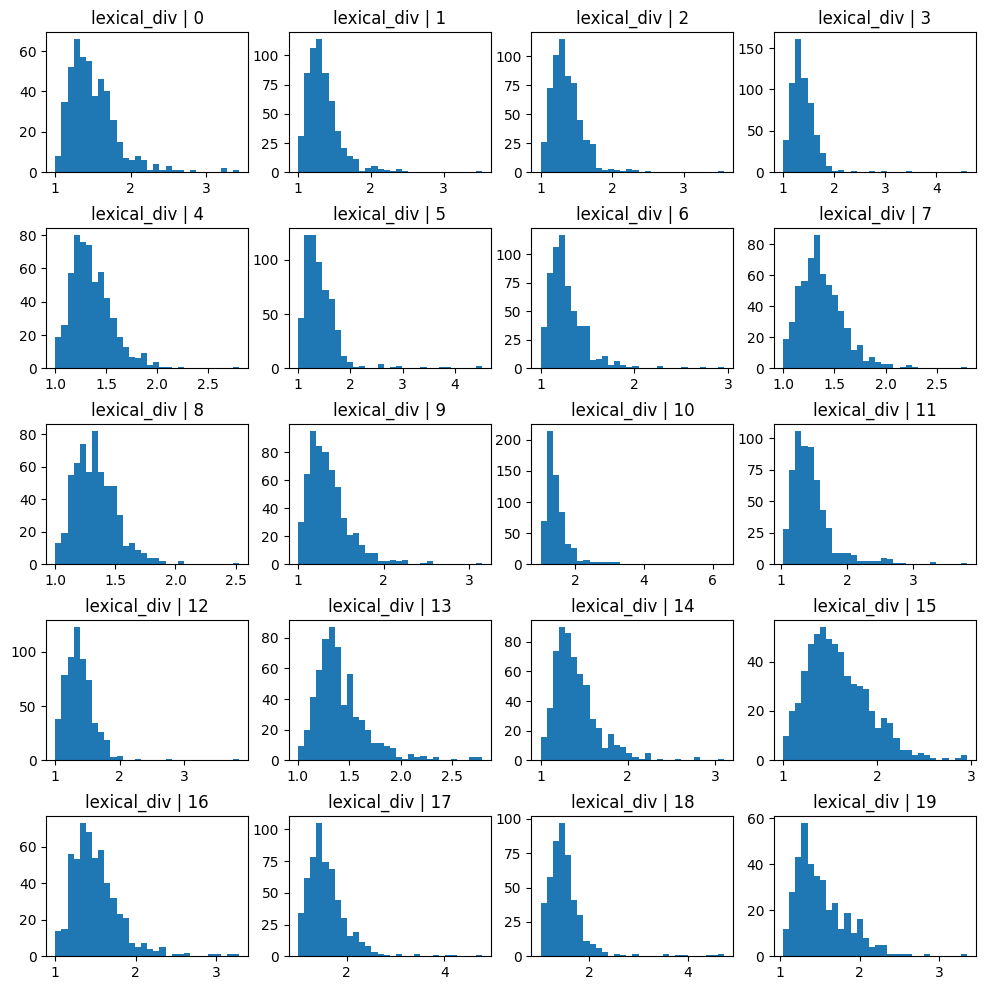

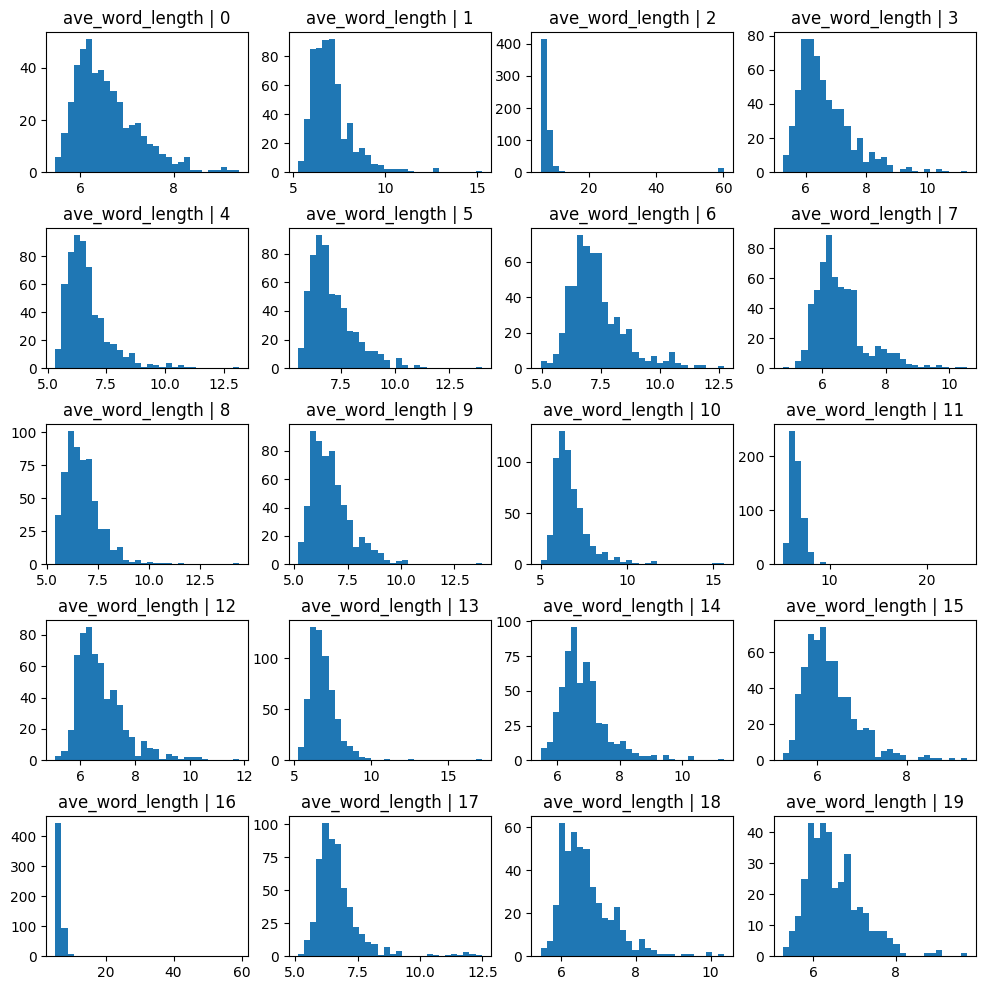

In [ ]:
import matplotlib.pyplot as plt

df['target'] = data.target

def plot_features(df, text_var):
  nb_rows = 5
  nb_cols = 4
  fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(12, 12))
  plt.subplots_adjust(wspace=None, hspace=0.4)
  n = 0
  for i in range(0, nb_rows):
    for j in range(0, nb_cols):
      axs[i, j].hist(df[df.target==n][text_var], bins=30)
      axs[i, j].set_title(text_var + ' | ' + str(n))
      n += 1
  plt.show()

plot_features(df, "lexical_div")
plot_features(df, "ave_word_length")

### 2.   Đánh giá độ phức tạp của văn bản thông qua đếm câu
Một khía cạnh của văn bản mà chúng ta có thể nắm bắt thông qua các đặc trưng là mức độ phức tạp của nó thông qua các câu trong văn bản. Thông thường, các văn bản dài chứa nhiều câu trải rộng qua nhiều đoạn văn có xu hướng cung cấp nhiều thông tin hơn so với các văn bản chỉ có rất ít câu. Do đó, việc xác định số lượng câu có thể cung cấp một số hiểu biết về lượng thông tin mà văn bản mang lại.

Quá trình phân tách được gọi là tokenize. Như ở mục 1. chúng ta đã sử dụng phân tách kí tự (character tokenize) và phân tách từ (word tokenize). Ở mục này chúng ta sẽ tiến hành phân tách câu (sentence tokenize), điều này hữu ích cho các tác vụ yêu cầu phân tích hoặc xử lý từng câu riêng lẻ (Ví dụ như tóm tắt văn bản, phân loại văn bản,...)

In [ ]:
import nltk
nltk.download('stopwords') # Tải stopwords
nltk.download('punkt') # Tải kí tự dấu câu
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import pandas as pd
from nltk.tokenize import sent_tokenize


text = """The alarm rang at 7 in the morning as it usually did on Tuesdays.
She rolled over, stretched her arm, and stumbled to the button till she finally
managed to switch it off. Reluctantly, she got up and went for a shower. The water was cold
as the day before the engineers
did not manage to get the boiler working. Good thing it was still
summer.
Upstairs, her cat waited eagerly for his morning snack. Miaow! he
voiced with excitement
as he saw her climb the stairs.
"""
sent_tokenize(text, "english")

['The alarm rang at 7 in the morning as it usually did on Tuesdays.',
 'She rolled over, stretched her arm, and stumbled to the button till she finally\nmanaged to switch it off.',
 'Reluctantly, she got up and went for a shower.',
 'The water was cold\nas the day before the engineers\ndid not manage to get the boiler working.',
 'Good thing it was still\nsummer.',
 'Upstairs, her cat waited eagerly for his morning snack.',
 'Miaow!',
 'he\nvoiced with excitement\nas he saw her climb the stairs.']

In [ ]:
new_df = df.iloc[0:10]
new_df['tokenized_text'] = new_df['text'].apply(lambda x: sent_tokenize(x, "english"))
new_df['num_sent'] = new_df['text'].apply(lambda x: len(sent_tokenize(x, "english")))
new_df.head()

<ipython-input-18-dbcb94d860f1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tokenized_text'] = new_df['text'].apply(lambda x: sent_tokenize(x, "english"))
<ipython-input-18-dbcb94d860f1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['num_sent'] = new_df['text'].apply(lambda x: len(sent_tokenize(x, "english")))


,text,num_char,num_words,num_vocab,lexical_div,ave_word_length,target,tokenized_text,num_sent
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,716,123,93,1.322581,5.821138,7,[From: lerxst@wam.umd.edu (where's my thing)\n...,9
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,857,123,99,1.242424,6.967480,4,[From: guykuo@carson.u.washington.edu (Guy Kuo...,7
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,1980,339,219,1.547945,5.840708,4,[From: twillis@ec.ecn.purdue.edu (Thomas E Wil...,9
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,814,113,96,1.177083,7.203540,1,[From: jgreen@amber (Joe Green)\nSubject: Re: ...,8
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,1117,171,139,1.230216,6.532164,14,[From: jcm@head-cfa.harvard.edu (Jonathan McDo...,10


### 3. Tạo thuộc tính thông qua kỹ thuật bag-of-words với n-grams, TF-IDF
Từ việc tạo ra các thuộc tính độ đa dạng về từ vựng, độ dài trung bình của từ, và số lượng câu trong văn bản, chúng ta có thể hiểu được độ phức tạp của cấu trúc của một văn bản. Tuy nhiên, các thuộc tính chưa thể hiện rõ ngữ cảnh, nội dung, thông tin nội hàm thông qua từ ngữ. Từ đây, chúng ta tiếp tục trích xuất những thông tin này thông qua việc tạo thêm thuộc tính thể hiện ngữ nghĩa cũng như nội dung văn bản dưới dạng dữ liệu số.


#### Túi từ vựng (Bag-of-words hay BoW)
Túi từ vựng là một phương pháp số hóa các thông tin của một đoạn văn bản dưới dạng các vector số. Cụ thể, các từ trong văn bản sẽ được thể hiện lại thông qua số lần xuất hiện của chúng trong một văn bản.<br>
Ví dụ: ``Dogs like cats, but cats do not like dogs`` khi thể hiện qua BoW

Dogs  | like | cats| but | do | not
------|------|------|------|------|------
2|2|2|1|1|1

Kỹ Thuật BoW là một kỹ thuật đơn giản và được sử dụng rất hữu hiệu trong những bài toán bao gồm:
 - Phân loại
 - Phân cụm
 - So sánh tương quan nội dung giữa các văn bản

In [ ]:
# Tạo một BoW đơn giản
def boW(text):
  word2count = {}
  words = nltk.word_tokenize(text)
  for word in words:
    if word not in word2count.keys():
      word2count[word] = 1
    else:
      word2count[word] += 1
  return word2count

df['bow'] = df['text'].apply(lambda x: boW(x).values())
df.head()

,text,num_char,num_words,num_vocab,lexical_div,ave_word_length,target,bow
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,716,123,93,1.322581,5.821138,7,"(1, 5, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 5, 3, ..."
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,857,123,99,1.242424,6.967480,4,"(1, 8, 2, 2, 2, 1, 2, 2, 1, 1, 4, 1, 1, 1, 2, ..."
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,1980,339,219,1.547945,5.840708,4,"(1, 7, 2, 2, 1, 6, 1, 1, 2, 6, 1, 1, 2, 4, 1, ..."
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,814,113,96,1.177083,7.203540,1,"(1, 10, 2, 5, 1, 2, 2, 2, 2, 1, 1, 3, 2, 3, 1,..."
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,1117,171,139,1.230216,6.532164,14,"(2, 7, 1, 5, 1, 3, 2, 1, 3, 1, 1, 1, 1, 1, 1, ..."


Tuy hiệu quả, song BoW vẫn gặp một số hạn chế. Những vấn đề sau đây liên quan đến mô hình Bag of Words (BOW) trong việc biểu diễn và phân tích văn bản:<br>

1. **Kích thước không gian lớn**:  
Không gian đặc trưng tạo ra có thể rất lớn, dẫn đến các vấn đề về quá khớp (overfitting) và hiệu suất tính toán.
2. **Thiếu thông tin ngữ cảnh**:  
Mô hình Bag of Words chỉ xem xét tần suất xuất hiện của các từ trong tài liệu, bỏ qua ngữ pháp, thứ tự từ và ngữ cảnh.
3. **Không nhạy cảm với mối liên hệ giữa các từ**:  
Mô hình Bag of Words không xem xét mối liên hệ giữa các từ cũng như các mối quan hệ ngữ nghĩa giữa chúng trong tài liệu.
4. **Thiếu thông tin ngữ nghĩa**:  
Vì chỉ xem xét các từ riêng lẻ, mô hình Bag of Words không nắm bắt được các mối quan hệ ngữ nghĩa hoặc ý nghĩa của từ trong ngữ cảnh.
5. **Tầm quan trọng của từ dừng**:  
Các từ dừng như “the”, “and”, “a”, v.v., có thể ảnh hưởng lớn đến cách biểu diễn văn bản trong mô hình Bag of Words, mặc dù chúng không mang nhiều ý nghĩa nhưng lại thường xuất hiện với tần suất lớn
6. **Tính thưa thớt**:  
Trong nhiều ứng dụng, biểu diễn văn bản bằng mô hình Bag of Words có thể rất thưa thớt, nghĩa là hầu hết các phần tử trong vector đặc trưng sẽ bằng không. Điều này có thể gây ra các vấn đề về hiệu suất tính toán và khó khăn trong việc diễn giải.

#### BoW n-grams
N-grams là kỹ thuật thay mà thay vì lấy một từ đơn thuần, chúng ta sẽ chọn một cụm từ nhằm thể hiện mối quan hệ giữa các từ trong câu hoặc văn bản. Số lượng từ chọn vào một cụm có thể từ 2 trở lên và được gọi là grams. <br>
Ví dụ: ``Dogs like cats, but cats do not like dogs`` khi thể hiện qua 2-grams, ta sẽ có:
- Dogs like
- Like cats
- but cats
- cats do
- do not
- not like
- like dogs

Kỹ thuật n-grams nhằm hỗ trợ bow thể hiện mối quan hệ giữa các từ trong câu

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import re


# Loại bỏ dấu câu
df['text'] = df['text'].apply(lambda x: re.sub('[^\w\s]', '', x)).apply(lambda x: re.sub('\d+', '', x))
# Tạo BoW n-grams
vectorizer = CountVectorizer(
    lowercase=True, # Chuẩn hóa toàn bộ từ về kiểu viết thường
    stop_words='english', # Chọn tập từ dừng tiếng Anh
    ngram_range=(1, 2), # Xác định độ lớn của một cụm, ở đây chọn n = 2 (2-grams)
    min_df=0.05 # Trả về những từ có tỉ lệ xuất hiện ít nhất là 5% trong văn bản
    )
# Khảm dữ liệu cho vectorizer
vectorizer.fit(df['text'])
# Tạo BoW
X = vectorizer.transform(df['text'])
bag_of_words = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names_out())
bag_of_words.head()

,able,access,actually,ago,apr,article,articleid,ask,available,away,...,world,writes,writes article,wrong,wrote,xnewsreader,year,years,yes,youre
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,1,1,1,0,1,1,0,0,0,0
4,0,0,0,0,0,2,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


#### Phương pháp TF-IDF
Term Frequency - Inverse Document Frequency (TF-IDF) là một thống kê số học giúp xác định mức độ quan trọng của một từ trong một tài liệu cụ thể so với toàn bộ tập hợp các tài liệu. TF-IDF phản ánh mức độ quan trọng của một từ trong một tài liệu so với toàn bộ tập hợp văn bản. Ý tưởng cơ bản là một từ xuất hiện thường xuyên trong một tài liệu nhưng hiếm khi xuất hiện trong toàn bộ tập hợp sẽ mang nhiều thông tin hơn so với một từ xuất hiện thường xuyên ở cả tài liệu lẫn toàn bộ tập hợp.<br>
Phương pháp bao gồm 2 phần:
1.  Term Frequency:<br>
Tần suất thuật ngữ xác định mức độ thường xuyên một thuật ngữ xuất hiện trong toàn bộ tài liệu. Nó có thể được xem như là xác suất tìm thấy một từ trong tài liệu. Tần suất này được tính bằng công thức:<br>
```
TF(t, d) = (Số lần xuất hiện từ t) / (Tổng số từ)
```
2.  Inverse Document Frequency:<br>
Dùng để đánh giá mức độ quan trọng của 1 từ trong văn bản. Khi tính tf mức độ quan trọng của các từ là như nhau. Tuy nhiên trong văn bản thường xuất hiện nhiều từ không quan trọng xuất hiện với tần suất cao như `the`, `a`,... IDF được tính theo công thức:<br>
```
IDF(t, D) = log(Số văn bản trong tập D /Số văn bản chứa từ t trong tập D)
```
Công thức tổng hợp của TF-IDF:
```
TF-IDF(t, d, D) = TF(t, d) * IDF(t, D)
```
TF-IDF được ứng dụng vào các tác vụ như:
-  Phân loại văn bản
-  So sánh văn bản
-  Tóm tắt văn bản
-  Tạo thuộc tính cho các tác vụ khác trong máy học


In [ ]:
import pandas as pd
from datasets import load_dataset
import re

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer


data = fetch_20newsgroups(subset='train')
df = pd.DataFrame(data.data, columns=['text'])
df['text'] = df['text'].apply(lambda x: re.sub('[^\w\s]', '', x)).apply(lambda x: re.sub('\d+', '', x))

vectorizer = TfidfVectorizer(lowercase=True,
                              stop_words='english',
                              ngram_range=(1, 2), # TF-IDF cũng có thể áp dụng n-grams như BoW
                              min_df=0.05)
vectorizer.fit(df['text'])
X = vectorizer.transform(df['text'])
tfidf = pd.DataFrame(X.toarray(), columns =vectorizer.get_feature_names_out())
tfidf.head()

,able,access,actually,ago,apr,article,articleid,ask,available,away,...,world,writes,writes article,wrong,wrote,xnewsreader,year,years,yes,youre
0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.265047,0.00000,0.0
1,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.333609,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0
2,0.0,0.133486,0.121833,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0
3,0.0,0.000000,0.000000,0.0,0.0,0.103593,0.000000,0.0,0.0,0.0,...,0.159704,0.094668,0.185075,0.0,0.205423,0.219904,0.0,0.000000,0.00000,0.0
4,0.0,0.000000,0.000000,0.0,0.0,0.259214,0.000000,0.0,0.0,0.0,...,0.000000,0.118440,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.26133,0.0


Tương tự như BoW, TF-IDF vẫn tồn tại một số bất cập bao gồm:
1. **Kích thước không gian lớn**:  
   Không gian đặc trưng tạo ra có thể rất lớn, dẫn đến các vấn đề về **quá khớp** (overfitting) và **hiệu suất tính toán**.

2. **Thiếu thông tin ngữ cảnh**:  
   TF-IDF chỉ xem xét tần suất của từ trong tài liệu, **bỏ qua ngữ cảnh và ý nghĩa của từ**.

3. **Phụ thuộc vào lĩnh vực**:  
   Kết quả của TF-IDF có thể phụ thuộc vào **lĩnh vực cụ thể**, vì tần suất và tầm quan trọng của các từ có thể thay đổi đáng kể giữa các lĩnh vực.

4. **Không nhạy cảm với mối liên hệ giữa các từ**:  
   TF-IDF không xét đến **mối quan hệ giữa các từ** hoặc mối quan hệ **ngữ nghĩa** trong tài liệu.

5. **Thiếu thông tin ngữ nghĩa**:  
   Vì chỉ xem xét từng từ riêng lẻ, TF-IDF không thể nắm bắt được **mối quan hệ ngữ nghĩa** hoặc **ý nghĩa của từ trong ngữ cảnh**.

###4. Làm sạch và chuẩn hóa dữ liệu với stemming và lemmatization
Một văn bản có thể phụ thuộc rất nhiều vào cách viết cá nhân của mỗi người. Nó bao gồm cả việc trình bày các kí tự in hoa, dấu câu, sử dụng các từ dừng (stopword), động từ, tính từ,... Nhưng đôi khi để nắm được thông tin, người đọc không cần thiết phải nắm hết toàn bộ những yếu tố đó mà chỉ cần nắm thông tin thông qua các từ khóa liên quan đến văn bản đó. Từ đây, việc chuẩn hóa văn bản và làm sạch văn bản trước khi trích xuất thông tin được áp dụng.<br>
Làm sạch dữ liệu văn bản hay còn gọi là tiền xử lý văn bản là các phương pháp nhằm loại bỏ những yếu tố có thể gây nhiễu thông tin trong một văn bản. Đó có thể là các kí tự đặt biệt, các dấu câu, khoảng trắng (whitespace), các từ dừng, hoặc đôi khi là dữ liệu số. Việc này làm giảm độ dài văn bản cũng như làm độ phức tạp của văn bản. Tuy nhiên, trong một số trường hợp cần nắm bắt chi tiết của văn bản, các kỹ thuật làm sạch dữ liệu dễ làm mất mát thông tin.

#### Làm sạch dữ liệu

In [ ]:
import pandas as pd
from datasets import load_dataset
from sklearn.datasets import fetch_20newsgroups
import nltk
from nltk.corpus import stopwords
import re
nltk.download('stopwords')
nltk.download('punkt')


data = fetch_20newsgroups(subset='train')
df = pd.DataFrame(data.data, columns=['text'])

# Loại bỏ dấu câu
df["text_wo_punc"] = df['text'].apply(lambda x: re.sub(r'[^\w\s]','',x))

# Loại bỏ số
df["text_wo_num"] = df['text'].apply(lambda x: re.sub(r'\d+','',x))

# Loại bỏ chữ in hoa
df["no_cap"] = df['text'].str.lower()

df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,text,text_wo_punc,text_wo_num,no_cap
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,From lerxstwamumdedu wheres my thing\nSubject ...,From: lerxst@wam.umd.edu (where's my thing)\nS...,from: lerxst@wam.umd.edu (where's my thing)\ns...
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,From guykuocarsonuwashingtonedu Guy Kuo\nSubje...,From: guykuo@carson.u.washington.edu (Guy Kuo)...,from: guykuo@carson.u.washington.edu (guy kuo)...
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,From twillisececnpurdueedu Thomas E Willis\nSu...,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,from: twillis@ec.ecn.purdue.edu (thomas e will...
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,From jgreenamber Joe Green\nSubject Re Weitek ...,From: jgreen@amber (Joe Green)\nSubject: Re: W...,from: jgreen@amber (joe green)\nsubject: re: w...
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,From jcmheadcfaharvardedu Jonathan McDowell\nS...,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,from: jcm@head-cfa.harvard.edu (jonathan mcdow...


In [ ]:
def remove_stopwords(text):
  stop = set(stopwords.words('english'))
  text = [word for word in text.split() if word not in stop]
  text = ' '.join(x for x in text)
  return text

df['no_stop'] = df['no_cap'].apply(lambda x: remove_stopwords(x))
df.head()

,text,text_wo_punc,text_wo_num,no_cap,no_stop
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,From lerxstwamumdedu wheres my thing\nSubject ...,From: lerxst@wam.umd.edu (where's my thing)\nS...,from: lerxst@wam.umd.edu (where's my thing)\ns...,from: lerxst@wam.umd.edu (where's thing) subje...
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,From guykuocarsonuwashingtonedu Guy Kuo\nSubje...,From: guykuo@carson.u.washington.edu (Guy Kuo)...,from: guykuo@carson.u.washington.edu (guy kuo)...,from: guykuo@carson.u.washington.edu (guy kuo)...
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,From twillisececnpurdueedu Thomas E Willis\nSu...,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,from: twillis@ec.ecn.purdue.edu (thomas e will...,from: twillis@ec.ecn.purdue.edu (thomas e will...
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,From jgreenamber Joe Green\nSubject Re Weitek ...,From: jgreen@amber (Joe Green)\nSubject: Re: W...,from: jgreen@amber (joe green)\nsubject: re: w...,from: jgreen@amber (joe green) subject: re: we...
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,From jcmheadcfaharvardedu Jonathan McDowell\nS...,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,from: jcm@head-cfa.harvard.edu (jonathan mcdow...,from: jcm@head-cfa.harvard.edu (jonathan mcdow...


#### Chuẩn hóa dữ liệu với stemming
Trong tiếng Anh, một từ ở nhiều thì, nhiều loại từ khác nhau trong nhiều trường hợp ngữ cảnh khác nhau. Nhằm giảm thiểu việc đếm tần xuất của từng loại từ như vậy, kỹ thuật stemming được áp dụng. Stemming sẽ loại bỏ tiền tố hoặc hậu tố của một từ nhằm đưa chúng về thể bình thường của nó, ví dụ `played`, `playing`, `plays` sẽ đều được chuyển về `play`. Stemming có 3 phương án:
- Poster stemming:  
Loại bỏ hậu tố dựa trên một quy tắc nhất định, có thể theo kinh nghiệm hoặc kỹ thuật cụ thể nhằm bắt được hậu tố của từ.
- Snowball stemming:  
Cũng là loại bỏ hậu tố như Poster stemming nhưng áp dụng nhiều nguyên tắt linh hoạt hơn trong thư viện.
- Lancaster stemming  
Đây là thư viện cải tiến của Snowball stemming, tuy nhiên đôi khi lại rút gọn quá mức hậu tố của đối tượng.

In [ ]:
import pandas as pd
from datasets import load_dataset
from sklearn.datasets import fetch_20newsgroups
import re

import nltk
from nltk.stem import PorterStemmer, LancasterStemmer
from nltk.stem.snowball import SnowballStemmer


data = fetch_20newsgroups(subset='train')
df = pd.DataFrame(data.data, columns=['text'])

stemmer = SnowballStemmer("english")

def stemm_words(text, stemmer):
  if stemmer == "poster":
    stemmer = PorterStemmer()
  elif stemmer == "snowball":
    stemmer = SnowballStemmer("english")
  elif stemmer == "lancaster":
    stemmer = LancasterStemmer()
  text = [stemmer.stem(word) for word in text.split()]
  text = ' '.join(x for x in text)
  return text

# Loại bỏ dấu câu
df["text"] = df['text'].apply(lambda x: re.sub(r'[^\w\s]','',x))

# Loại bỏ số
df["text"] = df['text'].apply(lambda x: re.sub(r'\d+','',x))

# Loại bỏ chữ in hoa
df["text"] = df['text'].str.lower()

df["snowball_stemmed"] = df["text"].apply(lambda x: stemm_words(x, "snowball"))
df.head()

,text,snowball_stemmed
0,from lerxstwamumdedu wheres my thing\nsubject ...,from lerxstwamumdedu where my thing subject wh...
1,from guykuocarsonuwashingtonedu guy kuo\nsubje...,from guykuocarsonuwashingtonedu guy kuo subjec...
2,from twillisececnpurdueedu thomas e willis\nsu...,from twillisececnpurdueedu thoma e willi subje...
3,from jgreenamber joe green\nsubject re weitek ...,from jgreenamb joe green subject re weitek p o...
4,from jcmheadcfaharvardedu jonathan mcdowell\ns...,from jcmheadcfaharvardedu jonathan mcdowel sub...


In [ ]:
df["lancaster_stemmed"] = df["text"].apply(lambda x: stemm_words(x, "lancaster"))
df["poster_stemmed"] = df["text"].apply(lambda x: stemm_words(x, "poster"))
df.head()

,text,lemmatizer,lancaster_stemmed,poster_stemmed
0,from lerxstwamumdedu wheres my thing\nsubject ...,from lerxstwamumdedu wheres my thing subject w...,from lerxstwamumdedu wher my thing subject wha...,from lerxstwamumdedu where my thing subject wh...
1,from guykuocarsonuwashingtonedu guy kuo\nsubje...,from guykuocarsonuwashingtonedu guy kuo subjec...,from guykuocarsonuwashingtonedu guy kuo subjec...,from guykuocarsonuwashingtonedu guy kuo subjec...
2,from twillisececnpurdueedu thomas e willis\nsu...,from twillisececnpurdueedu thomas e willis sub...,from twillisececnpurdueedu thoma e wil subject...,from twillisececnpurdueedu thoma e willi subje...
3,from jgreenamber joe green\nsubject re weitek ...,from jgreenamber joe green subject re weitek p...,from jgreenamber joe green subject re weitek p...,from jgreenamb joe green subject re weitek p o...
4,from jcmheadcfaharvardedu jonathan mcdowell\ns...,from jcmheadcfaharvardedu jonathan mcdowell su...,from jcmheadcfaharvardedu jonath mcdowell subj...,from jcmheadcfaharvardedu jonathan mcdowel sub...


Tuy nhanh chóng và linh hoạt trong việc chuẩn hóa dữ liệu văn bản, song stemming vẫn gặp một số nhược điểm:
-  Độ chính xác:
Có thể tạo ra các từ gốc không phải là từ thực tế, dẫn đến kết quả kém chính xác.

-  Rút gọn quá mức (Over-Stemming):
Đôi khi có thể loại bỏ quá nhiều phần của từ (ví dụ: "knowledge" thành "knowledg").

-  Rút gọn chưa đủ (Under-Stemming):
Đôi khi có thể loại bỏ quá ít phần của từ (ví dụ: "running" thành "runn").

Vì vậy, chỉ áp dụng stemming cần chú trọng vào tốc độ xử lý hơn độ chính xác, tài nguyên xử lý ít, áp dụng vào các bài toán tóm tắt và chuẩn hóa dữ liệu cho việc truy vấn.

#### Chuẩn hóa dữ liệu với lemmatization
Khác với Stemming là xử lý bằng cách loại bỏ các ký tự cuối từ một cách rất heuristic, Lemmatization sẽ xử lý thông minh hơn bằng một bộ từ điển hoặc một bộ ontology nào đó. Điều này sẽ đảm bảo rằng các từ như “goes“, “went” và “go” sẽ chắc chắn có kết quả trả về là như nhau. Kể các từ danh từ như mouse, mice cũng đều được đưa về cùng một dạng như nhau.<br>
Các kĩ thuật Lemmatization thường được áp dụng để xử lý từ vựng bao gồm:
-  Rule-based lemmatization:  
Cung cấp một bộ quy tắc nhằm chuẩn hóa và rút gọn từ vựng về bản gốc. Khác với machine learning - based, có sự can thiệp của máy học vào quy trình, rule-based dựa trên bộ quy tắt và mẫu từ gốc đã được định nghĩa từ trước. Tuy phương pháp này chưa thể bao quát được mọi sắc thái ngôn ngữ, rule-based vẫn cung cấp một phương pháp rõ ràng và minh bạch nhằm rút gọn về dạng cơ bản của các từ vựng.
-  Dictionary-based lemmatization:  
Phương pháp này cung cấp một bộ từ điển nhằm định hình các dạng cơ bản của các từ ngay từ đầu và thông qua quá trình tìm kiếm trên tự điển này để rút gọn các từ vựng về dạng cơ bản của chúng.
-  Machine Learning-Based Lemmatization:  
Như đã đề cầp, phương pháp này sẽ sử dụng một mô hình đã được huấn luyện (Mô hình mạng neuron hoặc mô hình thống kê) nhằm chuyển đổi các từ vựng về dạng cơ bản của chúng. Ưu điểm của phương pháp nằm ở khả năng của mô hình trong việc thích nghi với các sắc thái ngôn ngữ sẽ đa dạng và có khả năng xử lý các trường hợp bất quy tắc. Việc này làm phương pháp trở nên mạnh mẽ trong việc xác định bản gốc của từ cho các từ vựng phong phú.

In [ ]:
import pandas as pd
from datasets import load_dataset
from sklearn.datasets import fetch_20newsgroups
import re

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer


data = fetch_20newsgroups(subset='train')
df = pd.DataFrame(data.data, columns=['text'])

lemmatizer = WordNetLemmatizer()

def lemmatize_words(text):
  text = [lemmatizer.lemmatize(word) for word in text.split()]
  text = ' '.join(x for x in text)
  return text

# Loại bỏ dấu câu
df["text"] = df['text'].apply(lambda x: re.sub(r'[^\w\s]','',x))

# Loại bỏ số
df["text"] = df['text'].apply(lambda x: re.sub(r'\d+','',x))

# Loại bỏ chữ in hoa
df["text"] = df['text'].str.lower()

df["lemmatizer"] = df["text"].apply(lemmatize_words)
df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,lemmatizer
0,from lerxstwamumdedu wheres my thing\nsubject ...,from lerxstwamumdedu wheres my thing subject w...
1,from guykuocarsonuwashingtonedu guy kuo\nsubje...,from guykuocarsonuwashingtonedu guy kuo subjec...
2,from twillisececnpurdueedu thomas e willis\nsu...,from twillisececnpurdueedu thomas e willis sub...
3,from jgreenamber joe green\nsubject re weitek ...,from jgreenamber joe green subject re weitek p...
4,from jcmheadcfaharvardedu jonathan mcdowell\ns...,from jcmheadcfaharvardedu jonathan mcdowell su...


Lemmatization cung cấp một phương án có độ chính xác cao hơn so với stemming khi có các quy tắc chặc chẽ nhằm rút gọn từ vựng về dạng cơ bản của nó. Tuy nhiên, lemmatization cũng gặp một số nhược điểm bao gồm:

-  Triển khai phức tạp:  
Yêu cầu nhiều tài nguyên tính toán hơn và một từ điển toàn diện. Dù áp dụng phương án nào trong các phương án, lemmatization vẫn phải cần một bộ tự điển lớn và đa dạng làm cơ sở cho việc chuẩn hóa từ vựng
-  Sự phụ thuộc lớn vào POS tagging:  
POS tagging hay còn gọi là Part Of Speech là một kĩ thuật đánh nhãn loại từ cho văn bản nhằm xác định từ đó là danh từ, hay động từ, tính từ,... đồng thời thể hiện sự liên quan của từ đó so với các từ khác. Điều này dẫn đến việc nếu đánh nhãn loại từ sai sẽ dẫn đến kết quả sai lệch trong lemmatization.
-  Tốc độ xử lý:  
Vì thực hiện quá trình tìm kiếm từ liên quan trên bộ tự điển chuẩn hóa, quá trình lemmatization sẽ tốn thời gian xử lý hơn stemming  

Vì vậy, chỉ áp dụng lemmatization khi các tác vụ cần chú trọng vào độ chính xác xử lý hơn tốc độ, cần mức độ hiểu về ngữ nghĩa cao, nên áp dụng vào các bài toán như chatbot, phân tích ngữ cảnh, phiên dịch đa ngôn ngữ.

## Mô phỏng trên bài toán phân cụm

In [ ]:
import pandas as pd
from datasets import load_dataset
import re
import nltk
from nltk.corpus import stopwords
import pyvi
from pyvi import ViTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans


with open("/content/vietnamese-stopwords-dash.txt", "r") as f:
  stopwords = f.read().splitlines()

print(len(stopwords))
print(stopwords)
vn_data = load_dataset("nhantruongcse/summary-vietnamese-news")
df = pd.DataFrame(vn_data['train'])
df = df.rename(columns={'Content': 'text', "Summary": "summary"})
df.head()
print(df.info())
df = df.dropna()
print(df.info())
df =  df.loc[:10000]
print(df.info())

1998
['a_lô', 'a_ha', 'ai', 'ai_ai', 'ai_nấy', 'ai_đó', 'alô', 'amen', 'anh', 'anh_ấy', 'ba', 'ba_ba', 'ba_bản', 'ba_cùng', 'ba_họ', 'ba_ngày', 'ba_ngôi', 'ba_tăng', 'bao_giờ', 'bao_lâu', 'bao_nhiêu', 'bao_nả', 'bay_biến', 'biết', 'biết_bao', 'biết_bao_nhiêu', 'biết_chắc', 'biết_chừng_nào', 'biết_mình', 'biết_mấy', 'biết_thế', 'biết_trước', 'biết_việc', 'biết_đâu', 'biết_đâu_chừng', 'biết_đâu_đấy', 'biết_được', 'buổi', 'buổi_làm', 'buổi_mới', 'buổi_ngày', 'buổi_sớm', 'bà', 'bà_ấy', 'bài', 'bài_bác', 'bài_bỏ', 'bài_cái', 'bác', 'bán', 'bán_cấp', 'bán_dạ', 'bán_thế', 'bây_bẩy', 'bây_chừ', 'bây_giờ', 'bây_nhiêu', 'bèn', 'béng', 'bên', 'bên_bị', 'bên_có', 'bên_cạnh', 'bông', 'bước', 'bước_khỏi', 'bước_tới', 'bước_đi', 'bạn', 'bản', 'bản_bộ', 'bản_riêng', 'bản_thân', 'bản_ý', 'bất_chợt', 'bất_cứ', 'bất_giác', 'bất_kì', 'bất_kể', 'bất_kỳ', 'bất_luận', 'bất_ngờ', 'bất_nhược', 'bất_quá', 'bất_quá_chỉ', 'bất_thình_lình', 'bất_tử', 'bất_đồ', 'bấy', 'bấy_chầy', 'bấy_chừ', 'bấy_giờ', 'bấy_lâu', 'b

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/321 [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/165M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/161M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/164573 [00:00<?, ? examples/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164573 entries, 0 to 164572
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   text     164573 non-null  object
 1   summary  164573 non-null  object
dtypes: object(2)
memory usage: 2.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164573 entries, 0 to 164572
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   text     164573 non-null  object
 1   summary  164573 non-null  object
dtypes: object(2)
memory usage: 2.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     10001 non-null  object
 1   summary  10001 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB
None


### Làm sạch dữ liệu
Đối với dữ liệu tiếng Việt, chúng ta sẽ không sử dụng bước stemming và lemmatization vì dữ liệu tiếng Việt không chia loại từ theo thì và thể như tiếng Anh. Tuy nhiên, quá trình phân tách từ chúng ta phải dùng thư viện đặc thù vì tiếng Việt không phải từ độc lập như tiếng Anh mà sẽ có các từ ghép, từ láy,... có nhiều hơn 1 tiếng trong 1 từ. Như đã đề cập ở trên, ta sẽ sử dụng thư viện Pyvi để tách từ.

In [ ]:
def clean_data(text: str):
  text = text.strip(" ") # Loại bỏ khoảng trắng
  text = re.sub(r'[^\w\s]','',text) # Loại bỏ ký tự không phải chữ và dấu space
  text = re.sub(r'\d+','',text) # Loại bỏ dữ liệu số
  text = text.lower() # Chuẩn hóa dữ liệu in hoa
  text = ViTokenizer.tokenize(text) # Tách từ bằng tokenizer
  text = text.split(" ") # Phân tách từ theo khoảng trắng
  text = [word for word in text if word not in stopwords] # Loại bỏ từ dừng
  text = ' '.join(x for x in text)
  return text

In [ ]:
df["cleaned_text"] = df["summary"].apply(clean_data)
df.head()

,text,summary,cleaned_text
0,Hội nghị về giải pháp và định hướng phát triển...,"Trong khi hiệu quả của chăm sóc, điều trị bằng...",hiệu_quả chăm_sóc điều_trị tế_bào gốc người vi...
1,"Tại cuộc gặp mặt, Lào Saysomphone Phomvihane v...","Sáng 6.12, tại thủ đô Vientiane (Lào), trong k...",thủ_đô vientiane lào khuôn_khổ chuyến công_tác...
2,Tổ chức Hợp tác và phát triển kinh tế (OECD) v...,Kết quả PISA năm 2022 mà OECD vừa công bố cho ...,kết_quả pisa oecd công_bố học_sinh việt nam tụ...
3,Trao đổi với báo chí tại họp báo Chính phủ thư...,"Thứ trưởng Bộ GD-ĐT Hoàng Minh Sơn cho rằng, t...",thứ_trưởng gdđt hoàng minh sơn vụ_việc học_sin...
4,"Ngày 6.12, bà Vũ Thị Mai, Phó bí thư Thường tr...",Một phó bí thư thường trực Đảng ủy cấp xã vừa ...,phó bí_thư thường_trực đảng_ủy xã lực_lượng ch...


### Trích xuất đặc trưng
TF-IDF và BoW được sử dụng nhằm tạo đặc trưng cho dữ liệu

#### TF-IDF

In [ ]:
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
X = vectorizer.fit_transform(df['cleaned_text'])

tfidf = pd.DataFrame(X.toarray(), columns =vectorizer.get_feature_names_out())
tfidf.head()

,ac,accent,acecook,aeon,afc,aff,afp,ahn,air,airbus,...,ủy,ủy_ban,ủy_viên,ứng_cứu,ứng_cử_viên,ứng_dụng,ứng_phó,ứng_tuyển,ứng_viên,ứng_xử
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Bag-of-words

In [ ]:
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
bow_features = vectorizer.fit_transform(df['cleaned_text'])

bow = pd.DataFrame(bow_features.toarray(), columns =vectorizer.get_feature_names_out())
bow.head()

,ac,accent,acecook,aeon,afc,aff,afp,ahn,air,airbus,...,ủy,ủy_ban,ủy_viên,ứng_cứu,ứng_cử_viên,ứng_dụng,ứng_phó,ứng_tuyển,ứng_viên,ứng_xử
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Giảm số chiều của thuộc tính

In [ ]:
from sklearn.decomposition import PCA

def decomposition_pca(data: list, n_components: int=2):
    pca = PCA(n_components=2, random_state=42)
    reduced_data = pca.fit_transform(data)

    print(f"Original shape: {data.shape}")
    print(f"Reduced shape: {reduced_data.shape}")

    return reduced_data

n_components = 2
reduced_tfidf_data = decomposition_pca(X.toarray(), n_components)
reduced_bow_data = decomposition_pca(bow_features.toarray(), n_components)

# Lưu số chiều thuộc tính sau khi giảm
for i in range(n_components):
  x = reduced_tfidf_data[:, i]
  df[f"x_{i}_tfidf"] = x

for i in range(n_components):
  x = reduced_bow_data[:, i]
  df[f"x_{i}_bow"] = x

df.head()

Original shape: (10001, 4499)
Reduced shape: (10001, 2)
Original shape: (10001, 4499)
Reduced shape: (10001, 2)


,text,summary,cleaned_text,x_0_tfidf,x_1_tfidf,x_0_bow,x_1_bow
0,Hội nghị về giải pháp và định hướng phát triển...,"Trong khi hiệu quả của chăm sóc, điều trị bằng...",hiệu_quả chăm_sóc điều_trị tế_bào gốc người vi...,0.021391,0.061606,0.021391,0.061606
1,"Tại cuộc gặp mặt, Lào Saysomphone Phomvihane v...","Sáng 6.12, tại thủ đô Vientiane (Lào), trong k...",thủ_đô vientiane lào khuôn_khổ chuyến công_tác...,-0.026489,-0.155423,-0.026489,-0.155423
2,Tổ chức Hợp tác và phát triển kinh tế (OECD) v...,Kết quả PISA năm 2022 mà OECD vừa công bố cho ...,kết_quả pisa oecd công_bố học_sinh việt nam tụ...,-0.102559,-0.046303,-0.102559,-0.046303
3,Trao đổi với báo chí tại họp báo Chính phủ thư...,"Thứ trưởng Bộ GD-ĐT Hoàng Minh Sơn cho rằng, t...",thứ_trưởng gdđt hoàng minh sơn vụ_việc học_sin...,0.021688,-0.066067,0.021688,-0.066067
4,"Ngày 6.12, bà Vũ Thị Mai, Phó bí thư Thường tr...",Một phó bí thư thường trực Đảng ủy cấp xã vừa ...,phó bí_thư thường_trực đảng_ủy xã lực_lượng ch...,0.054274,-0.036346,0.054274,-0.036346


### Phân cụm với K-Mean

In [ ]:
from sklearn.cluster import KMeans
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import silhouette_score

#### Dùng phương pháp cùi chỏ (Elbow method)
Phương pháp elbow liên quan đến việc tìm số cụm tối ưu
𝐾 thông qua biểu đồ trực quan. Phương pháp này hoạt động bằng cách tính tổng bình phương khoảng cách trong cụm (WCSS - Within-Cluster Sum of Squares), tức là tổng bình phương khoảng cách giữa các điểm trong một cụm và tâm cụm của chúng.

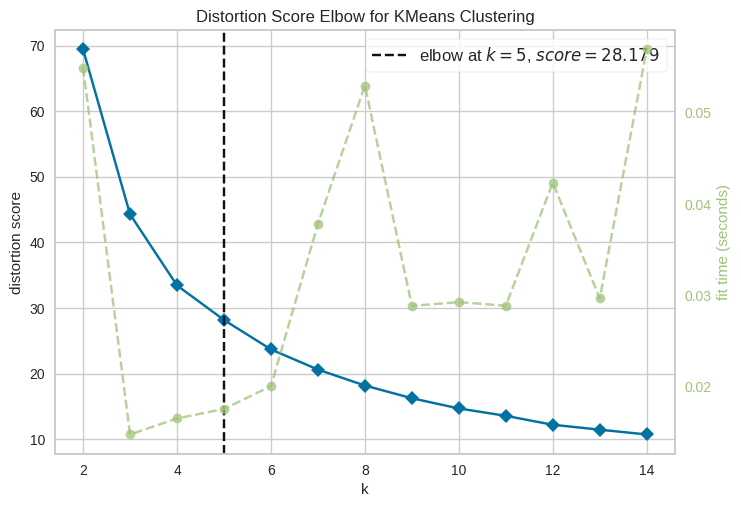

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

# Sử dụng yellowbreak khảo sát số cụm k với phương pháp cùi chỏ (elbow method)
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,15))

visualizer.fit(reduced_tfidf_data) # Khảm dữ liệu
visualizer.show()

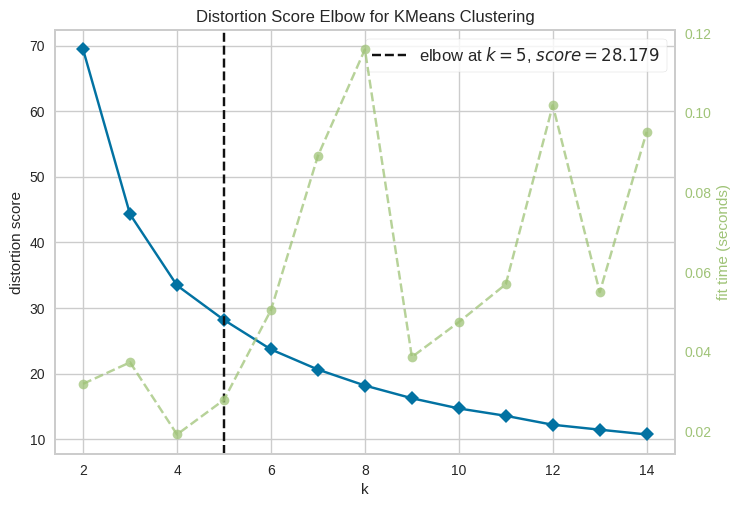

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# Sử dụng yellowbreak khảo sát số cụm k với phương pháp cùi chỏ (elbow method)
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,15))

visualizer.fit(reduced_bow_data)
visualizer.show()

#### Dùng phương pháp Silhouette
Phương pháp Silhouette là một trong các phương pháp tìm kiếm số lượng cụm K tối ưu. Giá trị Silhouette chạy từ [-1,1]. Trong đó:
- 1: Các cụm phân tách rõ ràng
- 0: Các cụm có phân tách nhưng chưa rõ ràng
- -1: Các cụm chưa thể hiện được sự phân tách

Công thức Silhouette được thể hiện:

```Silhouette Score = (b-a)/max(a,b)```

- a: Là khoảng cách trung bình giữa các điểm trong cụm.
- b: Là khoảng cách trung bình giữa các cụm

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

def sillihout_visualization(data: list, max_clusters: int=15, min_clusters: int=2):
  # Sử dụng Sillihout để tìm số cụm K phù hợp
  num_plots = max_clusters - min_clusters + 1
  rows = (num_plots + 1) // 2
  fig, axes = plt.subplots(rows, 2, figsize=(15, rows * 4))

  axes = axes.flatten()  # Flatten axes for easy iteration

  for i, n_clusters in enumerate(range(min_clusters, max_clusters + 1)):
      # Triển khai Kmeans
      km = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)

      # Khởi tạo Silhouette Visualizer
      visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=axes[i])
      visualizer.fit(data)

  # Adjust subplot spacing and hide unused axes
  for j in range(len(axes)):
    if j >= num_plots:
      axes[j].axis('off')
  # plt.tight_layout()
  plt.show()

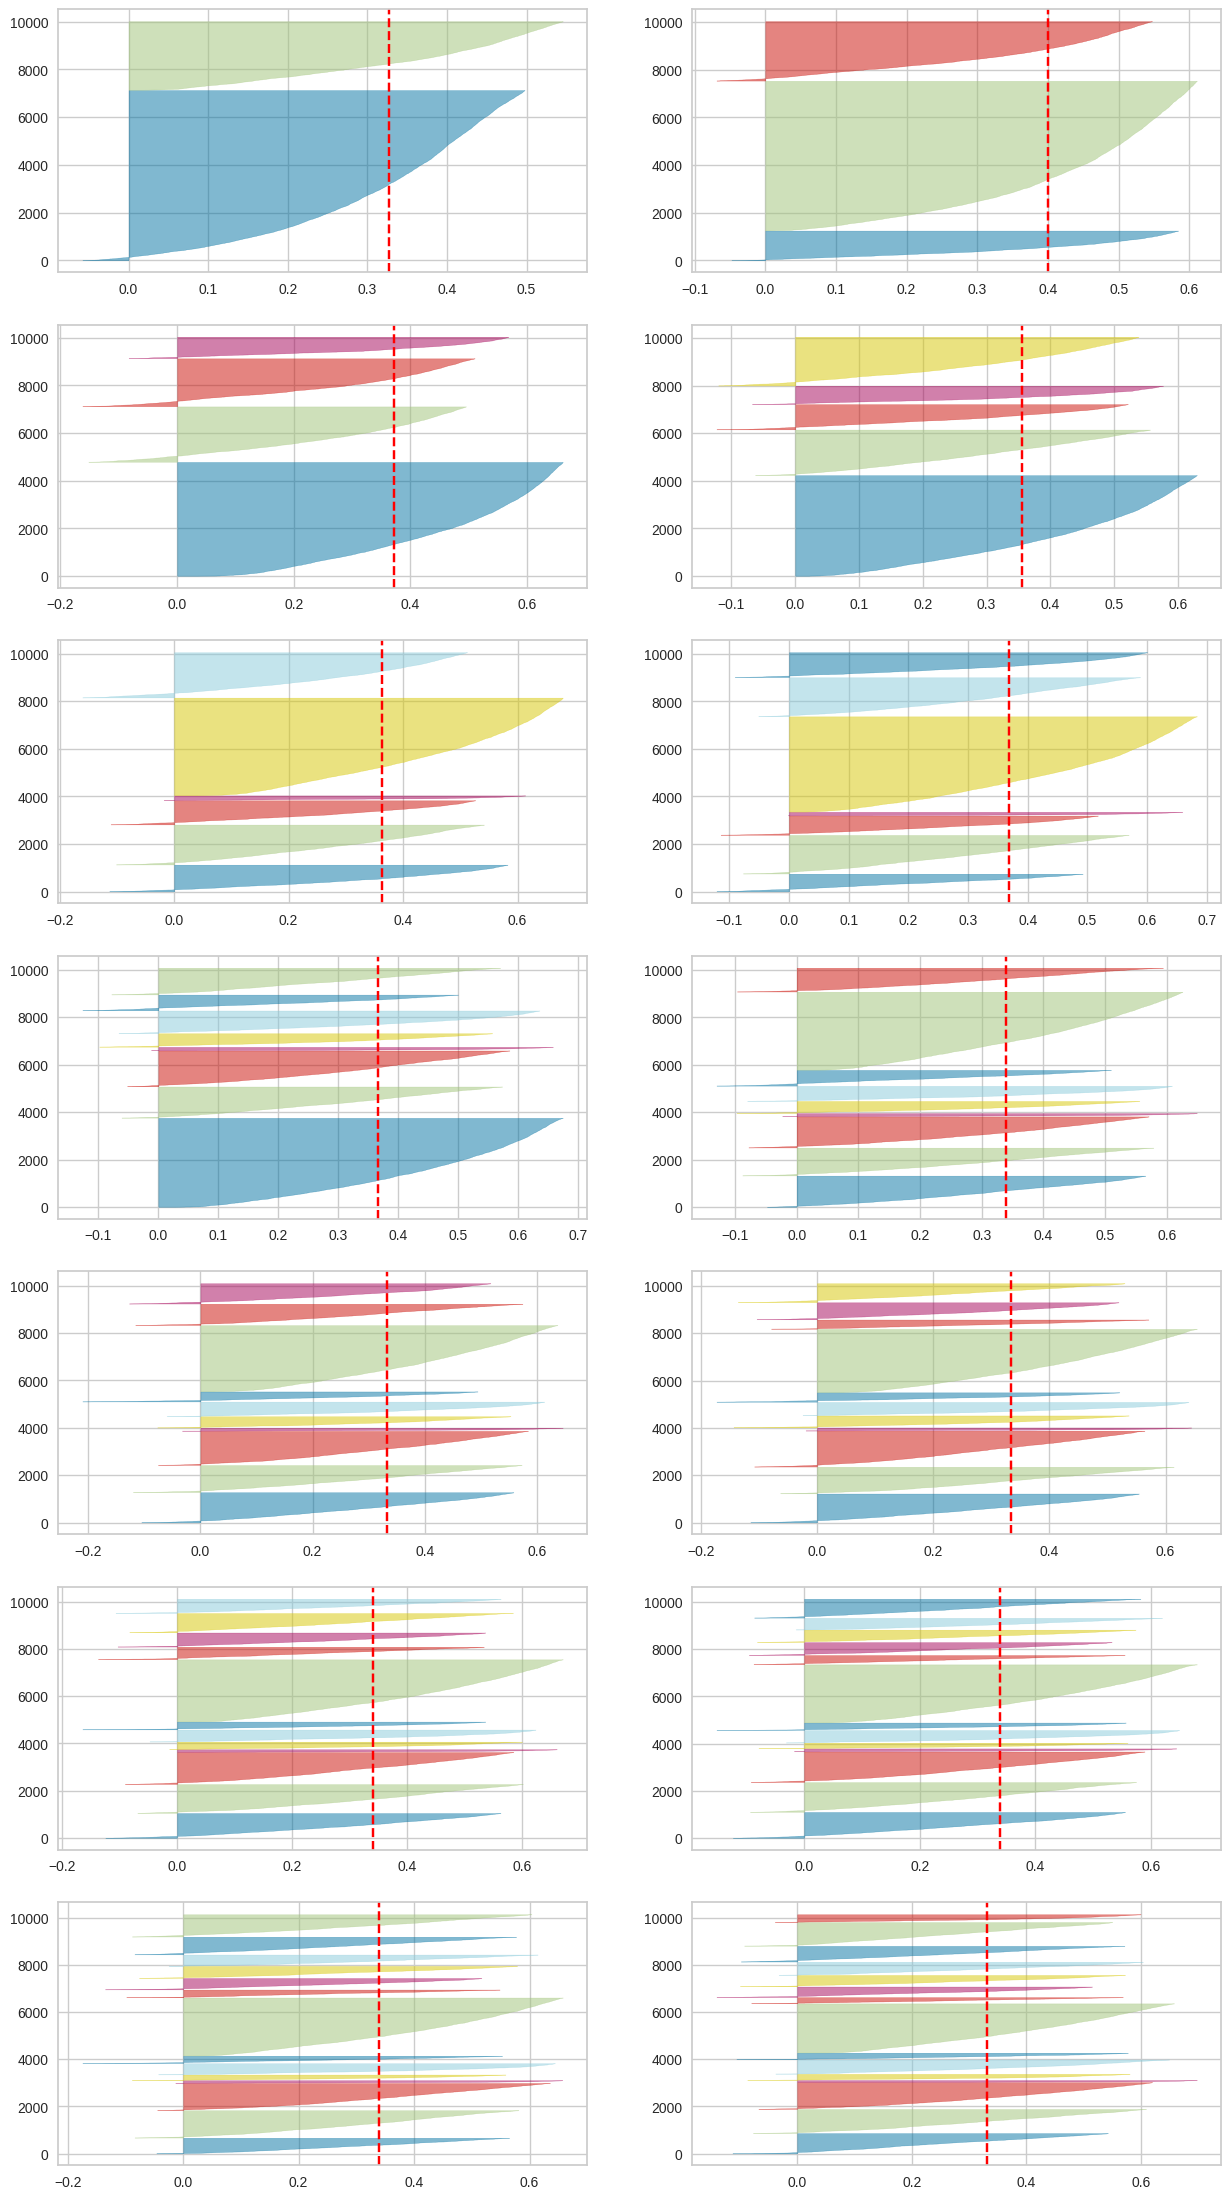

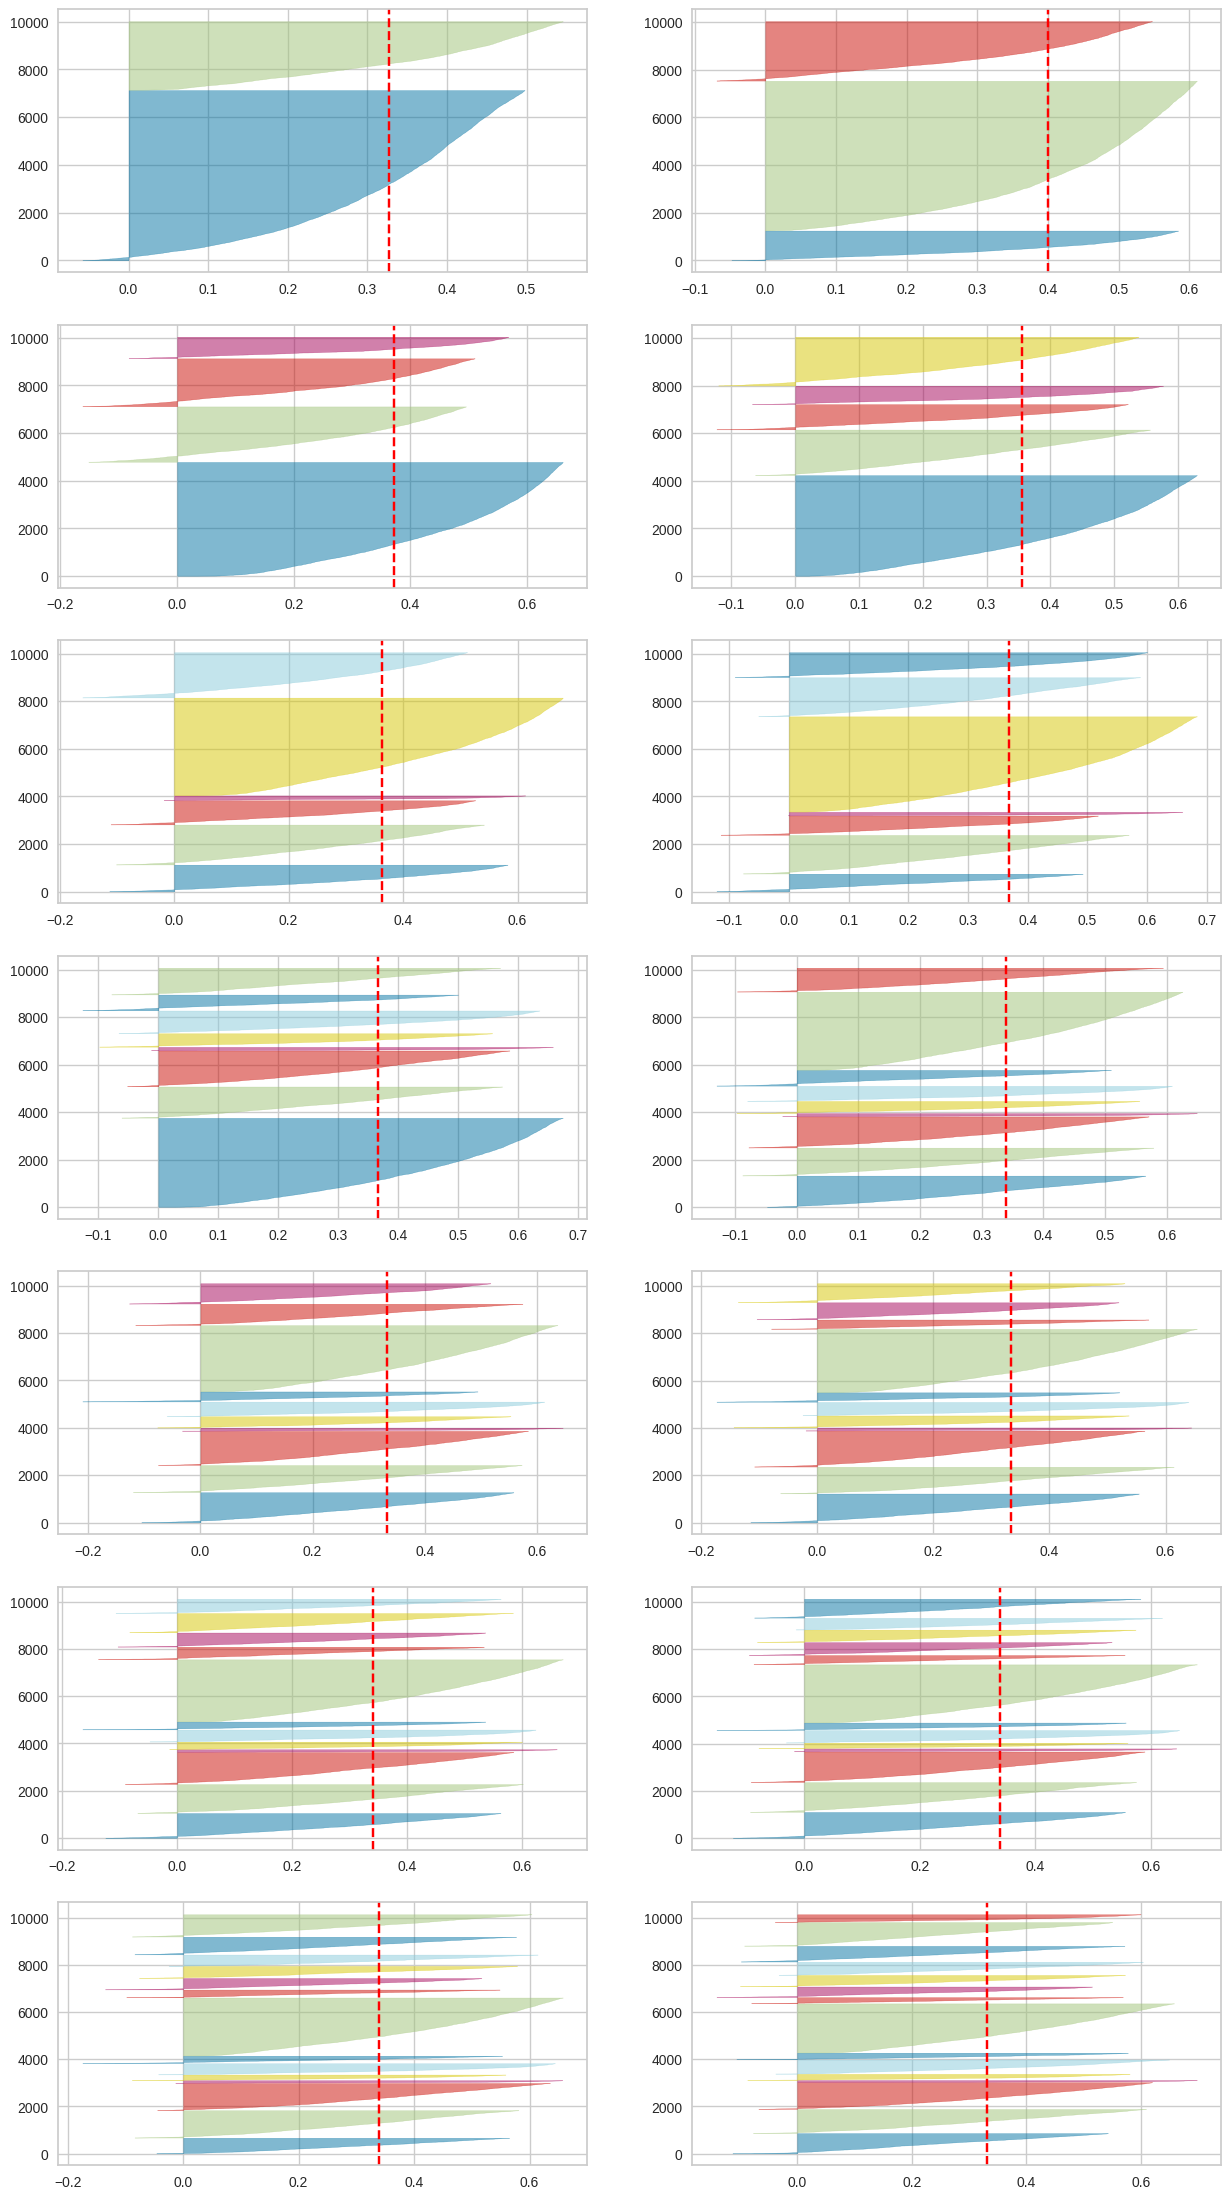

In [ ]:
sillihout_visualization(reduced_tfidf_data)
sillihout_visualization(reduced_bow_data)

In [ ]:
# K-Means clustering
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state = 42)
clusters = kmeans.fit_predict(reduced_bow_data)

df["kmean_cluster"] = clusters

print(df["kmean_cluster"].head())
print(df["kmean_cluster"].value_counts())

0    1
1    2
2    0
3    2
4    2
Name: kmean_cluster, dtype: int32
kmean_cluster
1    6269
2    2488
0    1244
Name: count, dtype: int64


### Hiển thị

In [ ]:
from collections import Counter

# Phân tích những từ xuất hiện nhiều trong các cụm
for cluster_num in range(num_clusters):
    cluster_texts = df[df['kmean_cluster'] == cluster_num]['cleaned_text']
    all_words = ' '.join(cluster_texts).split()
    most_common_words = Counter(all_words).most_common(10)
    print(f"Cluster {cluster_num}: {most_common_words}")

Cluster 0: [('nam', 529), ('việt', 491), ('giải', 321), ('việt_nam', 318), ('nữ', 254), ('trận', 226), ('diễn', 212), ('đội', 204), ('đội_tuyển', 202), ('vòng', 190)]
Cluster 1: [('người', 2191), ('xe', 639), ('mỹ', 582), ('đồng', 526), ('nước', 413), ('hàng', 408), ('dân', 405), ('nam', 399), ('tphcm', 395), ('triệu', 365)]
Cluster 2: [('tphcm', 832), ('tỉnh', 584), ('tổ_chức', 403), ('trường', 393), ('ubnd', 347), ('nguyễn', 331), ('thi', 327), ('dự_án', 282), ('chủ_tịch', 255), ('học_sinh', 221)]


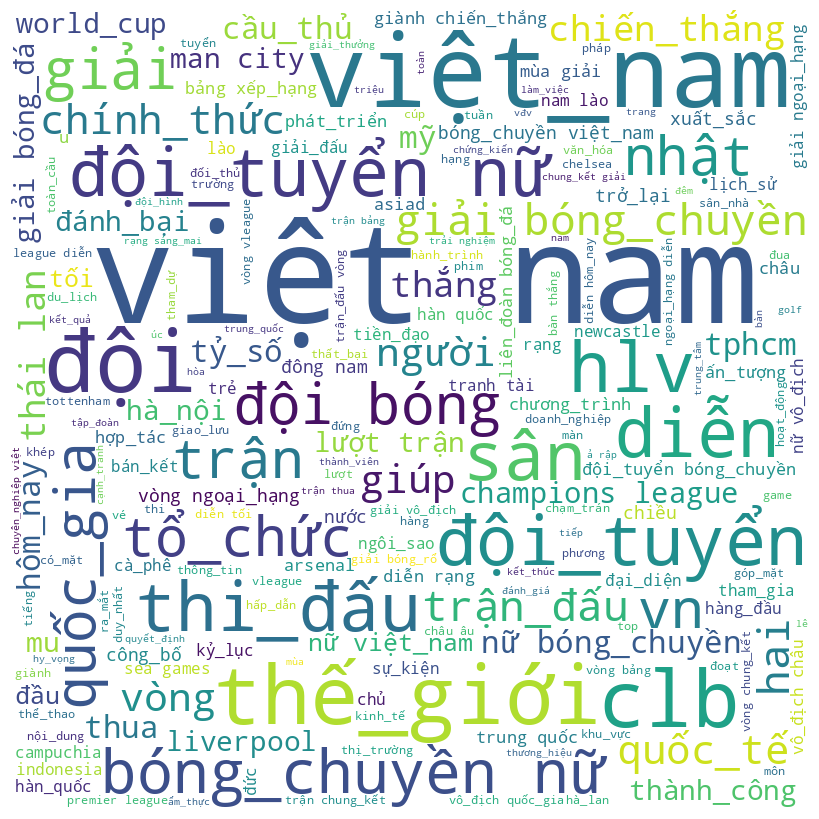

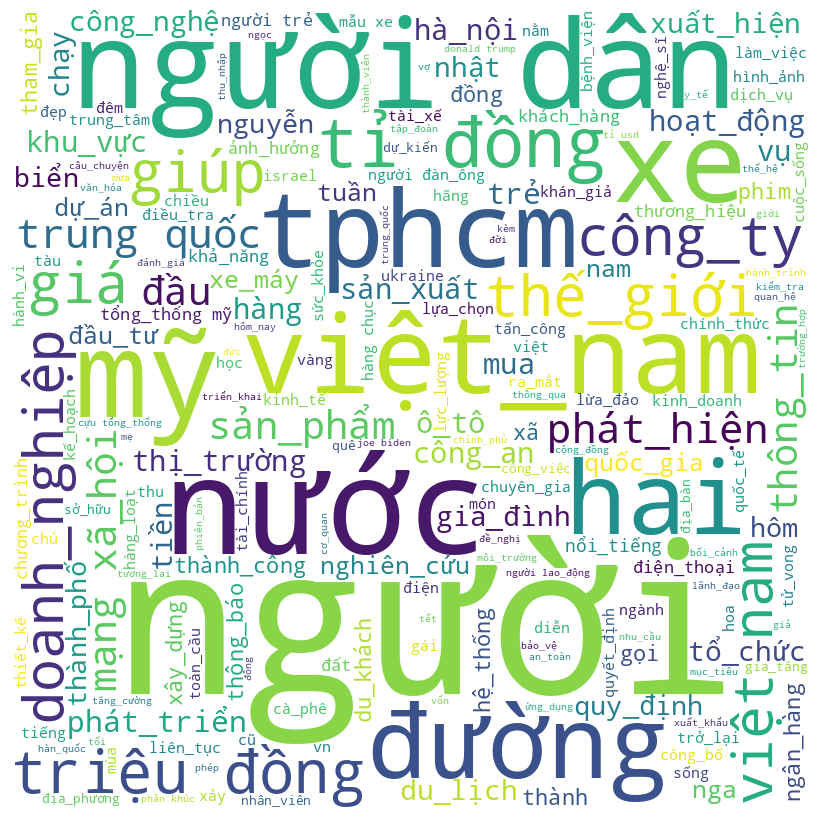

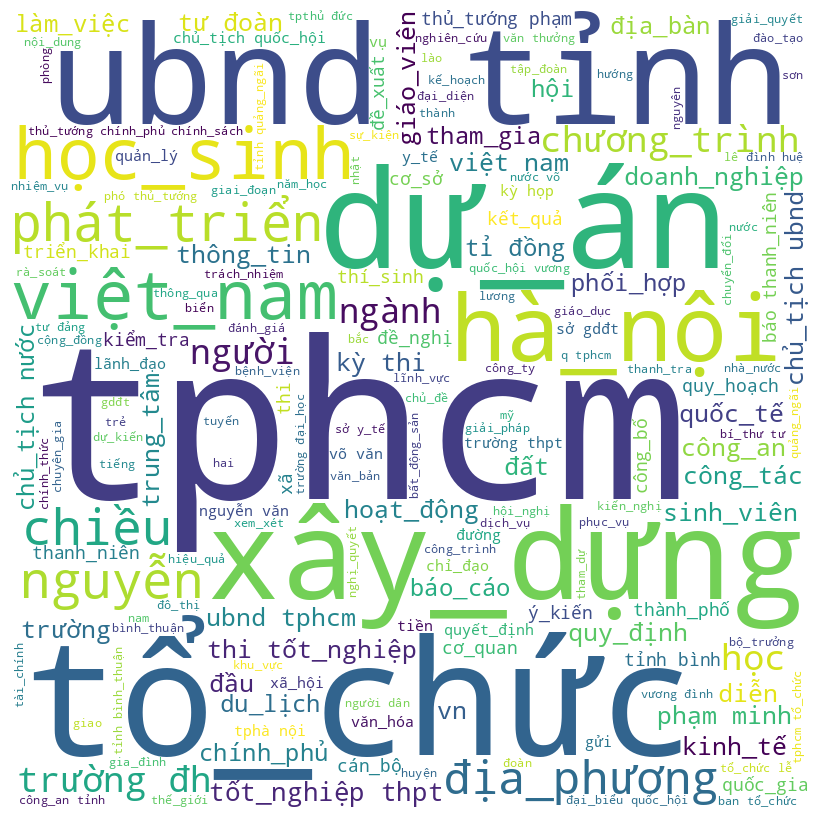

In [ ]:
from wordcloud import WordCloud

# Phân tích và tạo WordCloud cho các cụm
for cluster_num in range(num_clusters):
  # Lấy dữ liệu văn bản thuộc cụm hiện tại
  cluster_texts = df[df['kmean_cluster'] == cluster_num]['cleaned_text']

  # Gộp tất cả văn bản trong cụm thành một chuỗi
  all_words = ' '.join(cluster_texts)

  # Đếm tần suất các từ
  wordcloud = WordCloud(
              width = 800,
              height = 800,
              background_color ='white',
              min_font_size = 10).generate(all_words)

  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)

  plt.show()
  print("="*18)

In [ ]:
def plot_pca(data_df, x0_name, x1_name, cluster_name):

    plt.figure(figsize=(12, 7))

    plt.title(f"TF-IDF + KMeans Vietnamese news clustering with TF-IDF", fontdict={"fontsize": 18})
    plt.xlabel("X0", fontdict={"fontsize": 16})
    plt.ylabel("X1", fontdict={"fontsize": 16})

    sns.scatterplot(data=data_df, x=x0_name, y=x1_name, hue=cluster_name, palette="viridis")
    plt.show()

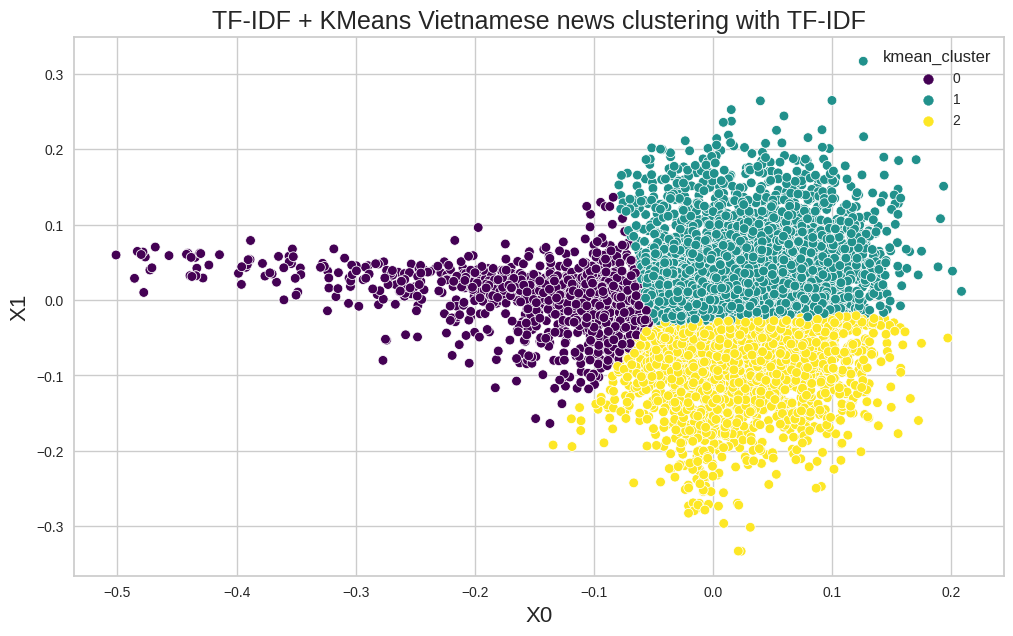

In [ ]:
plot_pca(df, "x_0_bow", "x_1_bow", "kmean_cluster")

In [1]:
from sklearn.metrics import silhouette_score

# Silhouette Score
score = silhouette_score(reduced_bow_data, clusters)
print("Silhouette Score:", score)

NameError: name 'reduced_bow_data' is not defined

## Tài liệu tham khảo
1. https://www.geeksforgeeks.org/lemmatization-vs-stemming-a-deep-dive-into-nlps-text-normalization-techniques/
2. https://www.geeksforgeeks.org/feature-extraction-techniques-nlp/
3.  https://builtin.com/data-science/elbow-method#:~:text=The%20elbow%20method%20is%20a%20graphical%20method%20for%20finding%20the,the%20graph%20forms%20an%20elbow.